# EDA & Feature Engineering
@Author: Bruno Vieira

Goals: Investigate some distributions, correlations and associations. Find Multicollinearity, plot low dimension representations to find patterns, perform feature engineering and feature selection algorithms to find the best  set of features to use in a classification task.

In [45]:
# Libs
import os
import json
import importlib

import numpy as np
import pandas as pd
import utils.dev.feature as ft
import utils.dev.cleaning as cl
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from operator import itemgetter
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.manifold import TSNE

pd.set_option('display.max_columns', 100)

In [58]:
# Paths and Filenames
DATA_INPUT_PATH = 'data/interim'
DATA_OUTPUT_PATH = DATA_INPUT_PATH
DATA_INPUT_NAME = 'train.csv'
DATA_OUTPUT_NAME = 'train_selected_features.csv'


In [3]:
df_twitter_train = pd.read_csv(os.path.join('..',DATA_INPUT_PATH, DATA_INPUT_NAME))

# 1) Feature Engineering

Let's create some features using the raw data We have.

In [4]:
df_twitter_train.columns

Index(['id', 'id_str', 'name', 'screen_name', 'location', 'profile_location',
       'description', 'followers_count', 'friends_count', 'listed_count',
       'created_at', 'favourites_count', 'geo_enabled', 'verified',
       'statuses_count', 'is_translation_enabled', 'profile_background_color',
       'profile_background_image_url', 'profile_background_image_url_https',
       'profile_background_tile', 'profile_image_url',
       'profile_image_url_https', 'profile_link_color',
       'profile_sidebar_border_color', 'profile_sidebar_fill_color',
       'profile_text_color', 'profile_use_background_image',
       'has_extended_profile', 'default_profile', 'default_profile_image',
       'label'],
      dtype='object')

In [5]:
list_columns_colors = df_twitter_train.filter(regex='color').columns.tolist()
# Length of name
df_twitter_train['name'] = df_twitter_train['name'].apply(lambda x: len(x) if x is not np.nan else 0)
# Length of screen name
df_twitter_train['screen_name'] = df_twitter_train['screen_name'].apply(lambda x: len(x) if x is not np.nan else 0)
# has profile location
df_twitter_train['profile_location'] = df_twitter_train['profile_location'].apply(lambda x: 'true' if x is not np.nan else 'false')
# Length of description
df_twitter_train['description'] = df_twitter_train['description'].apply(lambda x: len(x) if x is not np.nan else 0)
# rate (friends_count/followers_count)
df_twitter_train['rate_friends_followers'] = df_twitter_train['friends_count']/df_twitter_train['followers_count']
df_twitter_train['rate_friends_followers'] = df_twitter_train['rate_friends_followers'].replace({np.inf:0})
# has background image
df_twitter_train['has_background_image'] = df_twitter_train['profile_background_image_url'].apply(lambda x: 'true' if x is not np.nan else 'false')
# has image
df_twitter_train['profile_image_url_https'] = df_twitter_train['profile_image_url_https'].apply(lambda x: 'true' if x is not np.nan else 'false')
# Length Unique Colors 
df_twitter_train['unique_colors'] = df_twitter_train[list_columns_colors].stack().groupby(level=0).nunique()

In [6]:
df_twitter_train.columns

Index(['id', 'id_str', 'name', 'screen_name', 'location', 'profile_location',
       'description', 'followers_count', 'friends_count', 'listed_count',
       'created_at', 'favourites_count', 'geo_enabled', 'verified',
       'statuses_count', 'is_translation_enabled', 'profile_background_color',
       'profile_background_image_url', 'profile_background_image_url_https',
       'profile_background_tile', 'profile_image_url',
       'profile_image_url_https', 'profile_link_color',
       'profile_sidebar_border_color', 'profile_sidebar_fill_color',
       'profile_text_color', 'profile_use_background_image',
       'has_extended_profile', 'default_profile', 'default_profile_image',
       'label', 'rate_friends_followers', 'has_background_image',
       'unique_colors'],
      dtype='object')

In [7]:
columns_to_drop_useless = ['id', 'id_str', 'location', 'created_at', 'profile_background_color', 'profile_background_image_url', 'profile_background_image_url_https', 'profile_image_url', 
'profile_link_color', 'profile_sidebar_border_color', 'profile_sidebar_fill_color', 'profile_text_color']
df_twitter_train.drop(columns_to_drop_useless, axis=1, inplace=True)

# 2) Feature Selection

In [8]:
dict_dtypes = cl.check_dtypes(df_twitter_train)

In [9]:
dict_dtypes

{'int64': ['name',
  'screen_name',
  'description',
  'followers_count',
  'friends_count',
  'listed_count',
  'favourites_count',
  'statuses_count',
  'label',
  'unique_colors'],
 'object': ['profile_location',
  'geo_enabled',
  'verified',
  'is_translation_enabled',
  'profile_background_tile',
  'profile_image_url_https',
  'profile_use_background_image',
  'has_extended_profile',
  'default_profile',
  'default_profile_image',
  'has_background_image'],
 'float64': ['rate_friends_followers']}

In [10]:
num_columns = dict_dtypes['int64']+dict_dtypes['float64']
cat_columns = dict_dtypes['object']

## 2.1) Chi2

In [11]:
df_chi2, columns_to_drop_chi2, logs = ft.chi_squared(df_twitter_train, y='label', cat_columns=cat_columns, significance=0.05)


In [12]:
columns_to_drop_chi2

['verified',
 'profile_image_url_https',
 'profile_use_background_image',
 'has_extended_profile']

In [13]:
df_chi2

,column,p-value,chi2,results
0,profile_location,1.799285e-09,36.179772,Reject H0
1,geo_enabled,1.615945e-65,292.240277,Reject H0
2,verified,NaN,NaN,Accept H0
3,is_translation_enabled,2.263920e-31,135.749217,Reject H0
4,profile_background_tile,7.710182e-21,87.676064,Reject H0
5,profile_image_url_https,1.000000e+00,0.000000,Accept H0
6,profile_use_background_image,6.487110e-02,3.408253,Accept H0
7,has_extended_profile,6.063618e-02,3.519898,Accept H0
8,default_profile,1.087640e-70,315.980350,Reject H0
9,default_profile_image,1.285486e-10,41.330482,Reject H0


## 2.2) Point-biserial Correlation

In [14]:
df_pb, columns_to_drop_pb = ft.point_biserial(df_twitter_train, y='label', num_columns=num_columns, significance=0.05)

In [15]:
columns_to_drop_pb

['description']

In [16]:
df_pb

,column,correlation,p_value,result
0,name,0.047230,1.716575e-05,Reject H0
1,screen_name,0.080036,3.041508e-13,Reject H0
2,description,-0.001492,8.920661e-01,Accept H0
3,followers_count,-0.169829,1.310184e-54,Reject H0
4,friends_count,-0.029134,8.028960e-03,Reject H0
5,listed_count,-0.159058,4.878289e-48,Reject H0
6,favourites_count,0.052047,2.158847e-06,Reject H0
7,statuses_count,-0.074761,9.723232e-12,Reject H0
8,label,1.000000,0.000000e+00,Reject H0
9,unique_colors,-0.044009,6.190904e-05,Reject H0


In [17]:
df_twitter_train.drop(columns_to_drop_chi2+columns_to_drop_pb, axis=1, inplace=True)

## 2.3) Boruta

In [18]:
X = df_twitter_train.drop('label', axis=1)
y = df_twitter_train['label']

In [19]:
boruta_selector = ft.Boruta()
boruta_selector.fit(X, y, cat_columns=True, num_columns=True)

In [20]:
boruta_selector._columns_remove_boruta

['screen_name',
 'statuses_count',
 'is_translation_enabled',
 'default_profile',
 'default_profile_image',
 'has_background_image']

In [21]:
columns_to_drop_boruta = boruta_selector._columns_remove_boruta
df_twitter_train.drop(columns_to_drop_boruta, axis=1, inplace=True)

In [22]:
df_twitter_train

,name,profile_location,followers_count,friends_count,listed_count,favourites_count,geo_enabled,profile_background_tile,label,rate_friends_followers,unique_colors
0,5,true,15349596,692,45568,142,True,False,0,0.000045,5
1,17,false,0,44,0,7,False,False,1,0.000000,5
2,14,false,762839,475,3201,953,True,False,0,0.000623,4
3,17,false,327587,4801,1744,2946,True,False,0,0.014656,5
4,18,true,13324,647,44,729,False,False,1,0.048559,4
...,...,...,...,...,...,...,...,...,...,...,...
8273,12,false,10997,821,221,20115,False,False,0,0.074657,4
8274,13,false,44,637,0,298,False,False,1,14.477273,5
8275,16,false,342,849,0,2464,False,False,1,2.482456,4
8276,8,false,72,367,2,2634,False,False,1,5.097222,4


# 3) EDA

In [23]:
dict_dtypes = cl.check_dtypes(df_twitter_train)
num_columns = dict_dtypes['int64']+dict_dtypes['float64']
cat_columns = dict_dtypes['object']

100%|██████████| 8/8 [00:00<00:00, 25.26it/s]


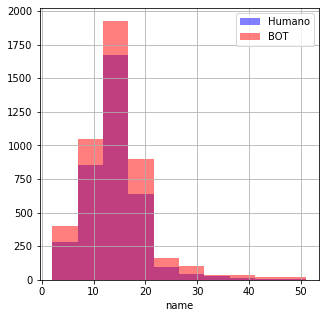

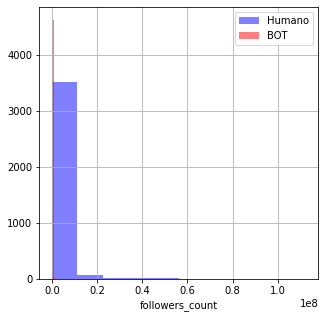

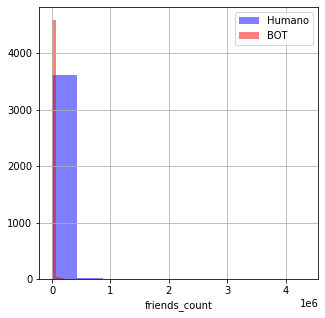

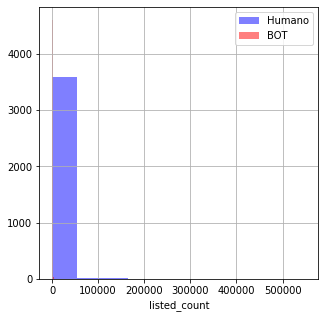

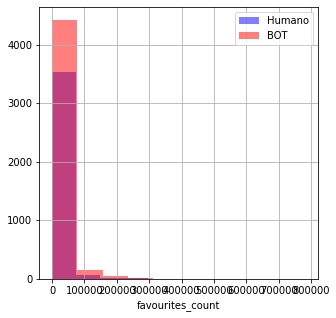

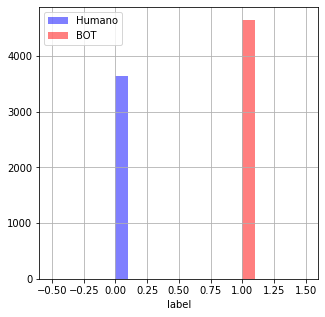

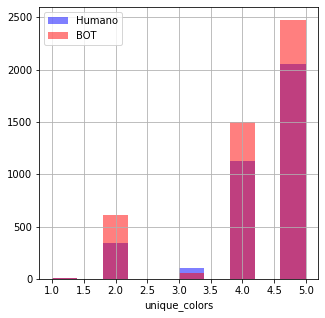

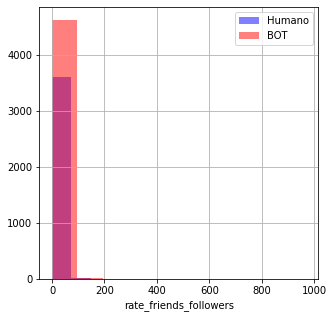

In [27]:
for col_num in tqdm(num_columns):
    plt.figure(figsize=(5,5))
    df_twitter_train[df_twitter_train['label']==0][col_num].hist(alpha = 0.5, color ='blue', label = 'Humano')
    df_twitter_train[df_twitter_train['label']==1][col_num].hist(alpha = 0.5, color = 'red', label = 'BOT')
    plt.legend()
    plt.xlabel(col_num)
plt.show()

In [28]:
df_twitter_train

,name,profile_location,followers_count,friends_count,listed_count,favourites_count,geo_enabled,profile_background_tile,label,rate_friends_followers,unique_colors
0,5,true,15349596,692,45568,142,True,False,0,0.000045,5
1,17,false,0,44,0,7,False,False,1,0.000000,5
2,14,false,762839,475,3201,953,True,False,0,0.000623,4
3,17,false,327587,4801,1744,2946,True,False,0,0.014656,5
4,18,true,13324,647,44,729,False,False,1,0.048559,4
...,...,...,...,...,...,...,...,...,...,...,...
8273,12,false,10997,821,221,20115,False,False,0,0.074657,4
8274,13,false,44,637,0,298,False,False,1,14.477273,5
8275,16,false,342,849,0,2464,False,False,1,2.482456,4
8276,8,false,72,367,2,2634,False,False,1,5.097222,4


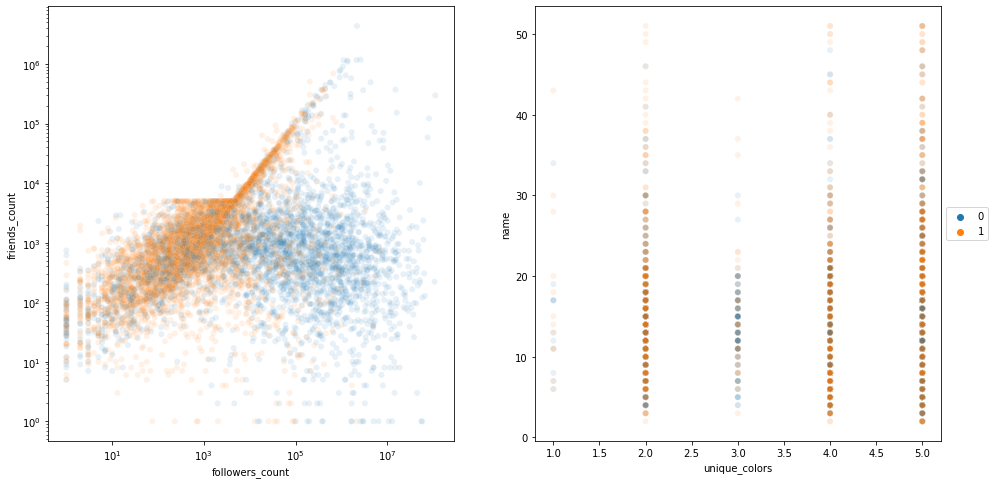

In [40]:
#df_twitter_train['friends_count_log'] = np.log(df_twitter_train['friends_count'])
#df_twitter_train['friends_count_log'] = np.log(df_twitter_train['friends_count'])
#Cria o grid
fig, ax = plt.subplots (1, 2, figsize = (16,8))
sns.scatterplot(x='followers_count', y='friends_count', hue='label', data=df_twitter_train, alpha=0.1, ax=ax[0],legend= False)
ax[0].set_yscale('log')
ax[0].set_xscale('log')
sns.scatterplot(x='unique_colors', y='name', hue='label', data=df_twitter_train, alpha=0.1, ax=ax[1])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.show()

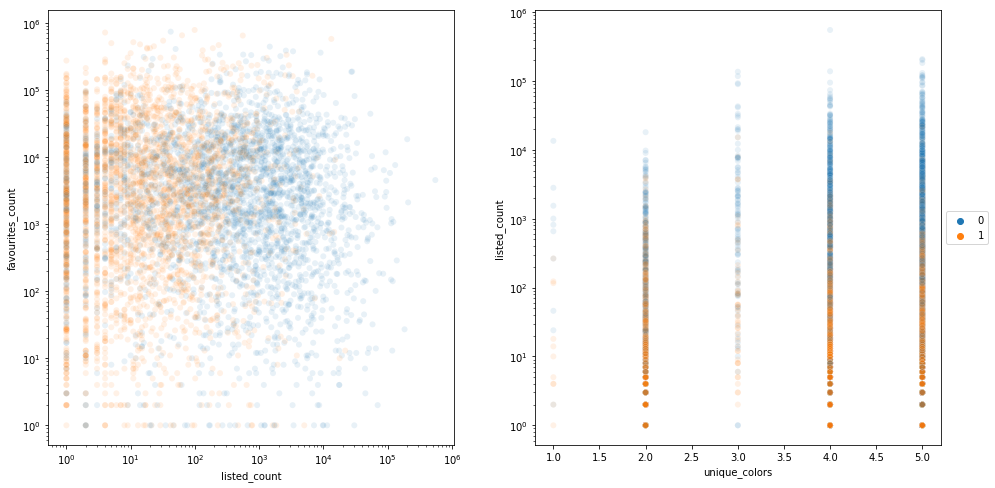

In [44]:
fig, ax = plt.subplots (1, 2, figsize = (16,8))
sns.scatterplot(x='listed_count', y='favourites_count', hue='label', data=df_twitter_train, alpha=0.1, ax=ax[0],legend= False)
ax[0].set_yscale('log')
ax[0].set_xscale('log')
sns.scatterplot(x='unique_colors', y='listed_count', hue='label', data=df_twitter_train, alpha=0.1, ax=ax[1])
ax[1].set_yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.show()

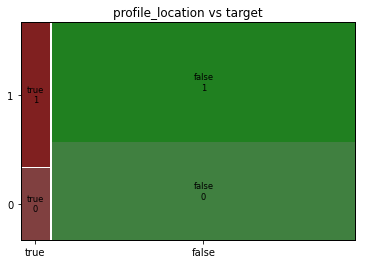

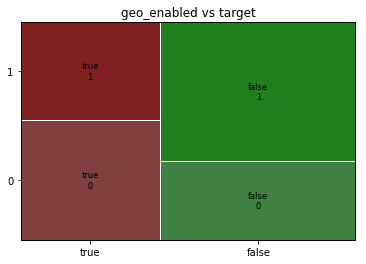

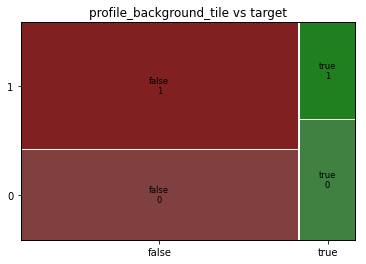

In [56]:
for col in cat_columns:
    mosaic(df_twitter_train, [col, 'label'])
    plt.title(f'{col} vs target')


- Distribution of Target 
- Distribution of Target x Features
- Low dimensional Representation
- Correlations

In [98]:
df_twitter_train['label'].value_counts(normalize=True)

,label
1,0.561247
0,0.438753


In [48]:
df_twitter_train = df_twitter_train.replace({'False ':'false', 'True ':'true'})
X_tsne = df_twitter_train.replace({'true':1, 'false':0}) 
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(X_tsne) 


/Users/bruno.santos/Desktop/Mestrado/mestrado_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/bruno.santos/Desktop/Mestrado/mestrado_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8278 samples in 0.008s...
[t-SNE] Computed neighbors for 8278 samples in 0.294s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8278
[t-SNE] Computed conditional probabilities for sample 2000 / 8278
[t-SNE] Computed conditional probabilities for sample 3000 / 8278
[t-SNE] Computed conditional probabilities for sample 4000 / 8278
[t-SNE] Computed conditional probabilities for sample 5000 / 8278
[t-SNE] Computed conditional probabilities for sample 6000 / 8278
[t-SNE] Computed conditional probabilities for sample 7000 / 8278
[t-SNE] Computed conditional probabilities for sample 8000 / 8278
[t-SNE] Computed conditional probabilities for sample 8278 / 8278
[t-SNE] Mean sigma: 41.947543
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.664757
[t-SNE] KL divergence after 1000 iterations: 0.795681


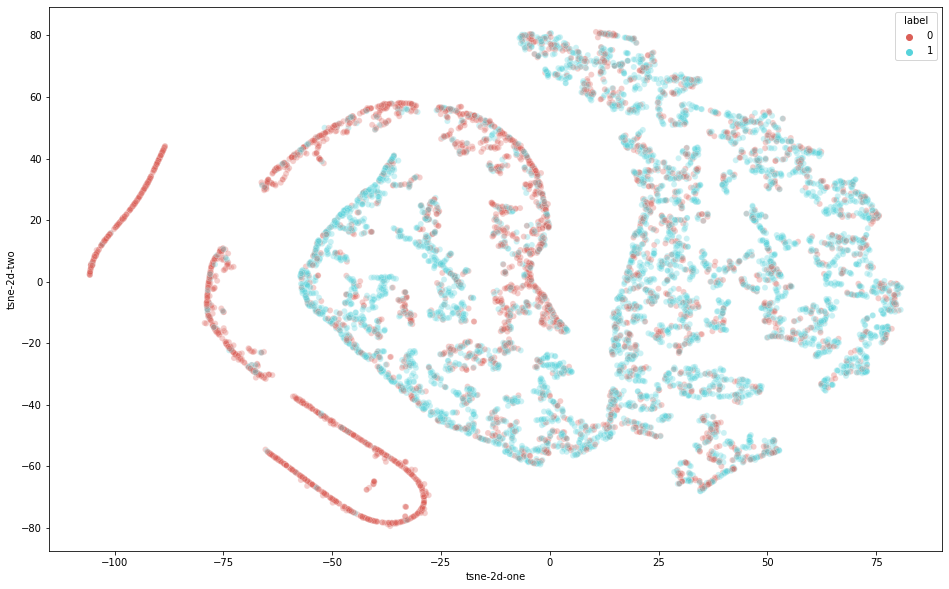

In [52]:
X_tsne['tsne-2d-one'] = z[:,0]
X_tsne['tsne-2d-two'] = z[:,1]
X_tsne['label'] = df_twitter_train['label']
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='tsne-2d-one', y='tsne-2d-two',
    hue='label',
    palette=sns.color_palette('hls', 2),
    data=X_tsne,
    legend='full',
    alpha=0.3
)
plt.show()

# 3) Saving the Data

Before We finish this step, I would drop some useless columns. All others will be feature engineered and evaluated as predictors in the step of Exploratory Data Analysis, Feature Engineering and Feature Selection

In [107]:
df_twitter_train.columns

Index(['id', 'id_str', 'name', 'screen_name', 'location', 'profile_location',
       'description', 'url', 'entities', 'followers_count', 'friends_count',
       'listed_count', 'created_at', 'favourites_count', 'geo_enabled',
       'verified', 'statuses_count', 'is_translation_enabled',
       'profile_background_color', 'profile_background_image_url',
       'profile_background_image_url_https', 'profile_background_tile',
       'profile_image_url', 'profile_image_url_https', 'profile_link_color',
       'profile_sidebar_border_color', 'profile_sidebar_fill_color',
       'profile_text_color', 'profile_use_background_image',
       'has_extended_profile', 'default_profile', 'default_profile_image'],
      dtype='object')

In [108]:
columns_to_keep = df_twitter_train.columns

In [59]:
# exporting final data to the interim folder
df_twitter_train.to_csv(os.path.join('..', DATA_OUTPUT_PATH, DATA_OUTPUT_NAME))
